# Préparation de l'environnement de travail

In [1]:
#mount your drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
#!ls drive/My\ Drive
import os

########## CHEMINS CI DESSOUS A MODIFIER ############
path_to_data = '/content/drive/My Drive/PSTALN/data'
###################################################
os.chdir(path_to_data)
!ls

0.png	16.png	5.png		     biobert_v1.1_pubmed_pytorch_model
10.png	17.png	6.png		     cord19-metadata.json
11.png	18.png	7.png		     folds
12.png	1.png	8.png		     litcovid.json
13.png	2.png	9.png		     scibert_uncased.tar
14.png	3.png	bibliovid.json	     train_data_loader
15.png	4.png	biobert_v1.1_pubmed  validation_data_loader


In [3]:
! pip install transformers

     |████████████████████████████████| 1.5MB 7.9MB/s 
     |████████████████████████████████| 2.9MB 30.9MB/s 
     |████████████████████████████████| 890kB 47.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=843e2d80fdec76c1f4396a63b47b90c98d0b3cccc4cc12b0a82388be28ad5ae8
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification,get_linear_schedule_with_warmup ,AdamW, DistilBertModel, DistilBertTokenizer, RobertaForSequenceClassification, RobertaTokenizer
import torch
import tensorflow as tf
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import transformers
from sklearn import metrics
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score, matthews_corrcoef
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import time
import datetime
import random
import matplotlib.pyplot as plt

In [5]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

# Importation des données

In [20]:
a = pd.read_json(path_to_data+'/bibliovid.json')
a

,id,slug,title,has_other_authors,impact_factor,goals_plain,verbose_date,authors,document_link,specialties,category,journal,link,results,synthesis,strength_of_evidence_details,goals,methods,pubmed_id,doi,abstract,topics,author_list,publication_date
0,769,body-mass-index-and-risk-for-intubation-or-dea...,Body Mass Index and Risk for Intubation or Dea...,True,"{'id': 3, 'name': 'Intermédiaire', 'posts_coun...",- Déterminer si l'obésité est associée à l'int...,31.07.2020,Anderson MR,https://www.acpjournals.org/doi/10.7326/M20-3214,"[{'id': 4, 'name': 'Anesthésie-Réanimation'}, ...","{'id': 6, 'name': 'Pronostique', 'icon': 'icon...","{'id': 41, 'name': 'Ann Intern Med'}",https://www.acpjournals.org/doi/10.7326/M20-3214,*Description de l'échantillon: 2112 patients c...,- Environ 2-3% des patients atteints de la COV...,-cohorte pronostique- puissance de l'étude sup...,- Déterminer si l'obésité est associée à l'int...,Cohorte rétrospective portant sur 2466 patient...,32726151,10.7326/M20-3214,Obesity is a risk factor for pneumonia and acu...,"[Pronostique, Anesthésie-Réanimation, Infectio...","[{'id': 714, 'name': 'Anderson MR'}]",2020-07-31
1,756,optimal-covid-19-epidemic-control-until-vaccin...,Optimal COVID-19 epidemic control until vaccin...,True,"{'id': 4, 'name': 'Indéterminé', 'posts_count'...",L'objectif de cette étude est de déterminer de...,22.07.2020,Djidjou-Demasse R,https://www.medrxiv.org/content/10.1101/2020.0...,"[{'id': 12, 'name': 'Infectiologie'}]","{'id': 8, 'name': 'Modélisation', 'icon': 'ico...","{'id': 85, 'name': 'Pre-prints'}",https://www.medrxiv.org/content/10.1101/2020.0...,Les auteurs montrent qu'une stratégie d’atténu...,Cet article détermine les méthodes de contrôle...,C'est un résultat très intéressant d'optimisat...,L'objectif de cette étude est de déterminer de...,Les auteurs considèrent un modèle relativement...,NaN,NaN,NaN,"[Modélisation, Infectiologie]","[{'id': 702, 'name': 'Djidjou-Demasse R'}]",2020-07-22
2,755,contact-rate-epidemic-control-of-covid-19-an-e...,Contact rate epidemic control of COVID-19: an ...,True,"{'id': 4, 'name': 'Indéterminé', 'posts_count'...",Le but de cet article est d'étudier l'impact d...,22.07.2020,Elie R,https://arxiv.org/pdf/2004.08221.pdf,"[{'id': 12, 'name': 'Infectiologie'}]","{'id': 8, 'name': 'Modélisation', 'icon': 'ico...","{'id': 85, 'name': 'Pre-prints'}",https://arxiv.org/pdf/2004.08221.pdf,Les auteurs calculent les stratégies optimales...,Les auteurs étudient un modèle SIR dont le tau...,Cet article présente de façon très pédagogique...,Le but de cet article est d'étudier l'impact d...,L'article utilise des méthodes classiques de t...,NaN,NaN,NaN,"[Modélisation, Infectiologie]","[{'id': 701, 'name': 'Elie R'}]",2020-07-22
3,543,hydroxychloroquine-in-the-treatment-and-prophy...,Hydroxychloroquine in the treatment and prophy...,True,"{'id': 3, 'name': 'Intermédiaire', 'posts_coun...","Tester, chez des macaques infectés par le SARS...",22.07.2020,Maisonnasse P,https://www.dropbox.com/s/cpg7cqcoyt0gv2e/v1.p...,"[{'id': 7, 'name': 'Transversale'}, {'id': 12,...","{'id': 4, 'name': 'Thérapeutique', 'icon': 'ic...","{'id': 189, 'name': 'Nature'}",https://www.dropbox.com/s/cpg7cqcoyt0gv2e/v1.p...,L'hydroxychloroquine a montré une activité ant...,Cette étude n'a montré ni activité antivirale ...,-\tPreprint-\tEssai randomisé chez les macaque...,"Tester, chez des macaques infectés par le SARS...",On a évalué l'activité antivirale de l'hydroxy...,NaN,NaN,NaN,"[Thérapeutique, Transversale, Infectiologie]","[{'id': 508, 'name': 'Maisonnasse P'}]",2020-07-22
4,757,covid-19-infectivity-profile-correction,COVID-19 infectivity profile correction,True,"{'id': 4, 'name': 'Indéterminé', 'posts_count'...",Le but de cette étude est de déterminer le pro...,22.07.2020,Ashcroft P,https://arxiv.org/pdf/2007.06602v1.pdf,"[{'id': 12, 'name': 'Infectiologie'}]","{'id': 8, 'name': 'Modélisation', 'icon': 'ico...","{'id': 85, 'name': 'Pre-prints'}",https://arxiv.org/pdf/2007.06602v1.pd

In [22]:
#Construction d'un dictionnaire avec les pécialités comme clés et des indices comme valeurs
spec_dict=dict()
spec_list=[]
for elt in a['specialties'].values:
    spec_list.append(elt[0]['name'])
spec_set=set(spec_list)
i=0
for elt in spec_set:
  spec_dict[elt]=i
  i+=1
print(spec_dict)
#Dorénavant on ne considère que les indices de ce dictionnaire pour l'dientification des spécialités

{'Neurologie': 0, 'Hygiène': 1, 'Hépato-gastro-entérologie': 2, 'Radiologie': 3, 'Confinement/Déconfinement': 4, 'Cardiologie et maladies métaboliques': 5, 'Pédiatrie': 6, 'Néphrologie': 7, 'Dermatologie': 8, 'Pneumologie': 9, 'Anesthésie-Réanimation': 10, 'Immunité': 11, 'Gériatrie': 12, 'Transversale': 13, 'Psychiatrie': 14, 'Infectiologie': 15, 'Hématologie': 16, 'Gynécologie Obstétrique': 17, 'Virologie': 18}


In [23]:
#Transformer le contenu de la case spécialties de la ligne i en un vecteur de 0 et de 1
def to_one_hot_labels(df,i):
  dic_label = df['specialties'][i]
  res = np.zeros(19) # 19 specialités possibles
  for dic in dic_label:
    n = dic['name']
    indice = spec_dict[n]
    res[indice] = 1 # encoder la présence de la spécialité n
  return res



def prepare_df(df,spec):
  df = df[['abstract','specialties']]
  labels = []
  s = []

  for i in range(df.shape[0]):
    if type(df['abstract'][i]) != str:
      s.append(i) #Si il n'y a pas d'abstract, la case a une valeur None  

    else:
      l = to_one_hot_labels(df,i)[spec_dict[spec]]
      labels.append(int(l)) 
    
  df = df.drop(s) # Supprimer les lignes sans abstract
  

  texts = df.abstract.values
  labels = np.array(labels)

  return texts, labels

#exemple
texts, labels = prepare_df(a,'Transversale')
print(texts[1], labels[1])


The severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) emerged in late 2019 and spread globally, prompting an international effort to accelerate development of a vaccine. The candidate vaccine mRNA-1273 encodes the stabilized prefusion SARS-CoV-2 spike protein.
We conducted a phase 1, dose-escalation, open-label trial including 45 healthy adults, 18 to 55 years of age, who received two vaccinations, 28 days apart, with mRNA-1273 in a dose of 25 μg, 100 μg, or 250 μg. There were 15 participants in each dose group.
After the first vaccination, antibody responses were higher with higher dose (day 29 enzyme-linked immunosorbent assay anti-S-2P antibody geometric mean titer [GMT], 40,227 in the 25-μg group, 109,209 in the 100-μg group, and 213,526 in the 250-μg group). After the second vaccination, the titers increased (day 57 GMT, 299,751, 782,719, and 1,192,154, respectively). After the second vaccination, serum-neutralizing activity was detected by two methods in all participan

# Le modèle

In [14]:
def format_time(elapsed):
    '''
    Prend le temps en secondes and reviens un string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))

    return str(datetime.timedelta(seconds=elapsed_rounded))

#Pour le calcul de l'accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Le modèle du classifieur binaire

In [27]:
#Pour chaque spécificité on construit un modèle de classifieur binaire
def model_of_spec(spec):
  t,l = prepare_df(a,spec)

  #test data
  texts_test = t[300:]
  labels_test = l[300:]

  #train et validation data
  texts = t[0:300]
  labels = l[0:300]

  # Tokenization des textes

  #tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

  tokenizer = RobertaTokenizer.from_pretrained('roberta-base',do_lower_case=False)
  input_ids = []
  for t in texts:
      encoded_t = tokenizer.encode(
                          t,                     
                          add_special_tokens = True)
      input_ids.append(encoded_t)

  # We'll borrow the `pad_sequences` utility function to do this.
  MAX_LEN = 100

  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                            value=0, truncating="post", padding="post")



  # Creation des attention masks
  attention_masks = []
  for sent in input_ids:
      att_mask = [int(token_id > 0) for token_id in sent]
      attention_masks.append(att_mask)
    
  #90% pour entraînement et 10% pour validation.
  train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                              random_state=2018, test_size=0.1)
  train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                              random_state=2018, test_size=0.1)
  
  #Transformation en tensors
  train_inputs = torch.tensor(train_inputs)
  validation_inputs = torch.tensor(validation_inputs)

  train_labels = torch.tensor(train_labels)
  validation_labels = torch.tensor(validation_labels)

  train_masks = torch.tensor(train_masks)
  validation_masks = torch.tensor(validation_masks)


  batch_size = 32

  #Le DataLoader de l'entrainement
  train_data = TensorDataset(train_inputs, train_masks, train_labels)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

  #Le DataLoader de la validation 
  validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
  validation_sampler = SequentialSampler(validation_data)
  validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


   #upload du modèle
  
  #model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2,output_attentions = False, output_hidden_states = False)

  num_labels = 2
  model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels)

  # Lancer le modèle dans le GPU.
  model.cuda()
  import random


  seed_val = 42

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  # On garde les valeurs du loss pour la représentation graphique
  loss_values = []
  epochs =4
  optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )
  total_steps = len(train_dataloader) * epochs
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

  #La boucle...
  for epoch_i in range(0, epochs):
      
      # ========================================
      #               Entrînement
      # ========================================
      

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Entrainement...')

      # Mesure du temps que prend chaque Epochs.
      t0 = time.time()
      # loss mis à zéro.
      total_loss = 0
      model.train()

      for step, batch in enumerate(train_dataloader):

          if step % 40 == 0 and not step == 0:
              elapsed = format_time(time.time() - t0)
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)

          model.zero_grad()        

          outputs = model(b_input_ids, 
                      token_type_ids=None, 
                      attention_mask=b_input_mask, 
                      labels=b_labels)
          

          loss = outputs[0]
          total_loss += loss.item()
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
          optimizer.step()
          scheduler.step()

      # calcul du loss moyen
      avg_train_loss = total_loss / len(train_dataloader)            
      loss_values.append(avg_train_loss)

      print("")
      print(" loss Moyen de l'entrainement: {0:.2f}".format(avg_train_loss))
      print("  Training epcoh a pris: {:}".format(format_time(time.time() - t0)))
          
      # ========================================
      #               Validation
      # ========================================
      print("")
      print("Lancement de Validation...")

      t0 = time.time()

      #le modèle est en mode évaluation
      model.eval()

      # les variables de la validation 
      eval_loss, eval_accuracy = 0, 0
      nb_eval_steps, nb_eval_examples = 0, 0

      for batch in validation_dataloader:
          
          # Ajout du batch au GPU
          batch = tuple(t.to(device) for t in batch)
          
    
          b_input_ids, b_input_mask, b_labels = batch
          
          # Pour accélérer le process
          with torch.no_grad():        
              outputs = model(b_input_ids, 
                              token_type_ids=None, 
                              attention_mask=b_input_mask)
          logits = outputs[0]

          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()
          
          tmp_eval_accuracy = flat_accuracy(logits, label_ids)
          
          eval_accuracy += tmp_eval_accuracy

          nb_eval_steps += 1

      print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
      print("  Validation a pris: {:}".format(format_time(time.time() - t0)))

  print("")
  print("Entrainement terminé!")

  #Représentation de l'évolution du loss è chaque epoch d'entraînement
  % matplotlib inline

  import seaborn as sns
  sns.set(style='darkgrid')

  sns.set(font_scale=1.5)
  plt.rcParams["figure.figsize"] = (12,6)


  plt.plot(loss_values, 'b-o')

  plt.title(f"{spec} : Training loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.savefig(f"{spec_dict[spec]}.png")
  plt.show()
  
  

  # Test
   
  print('Nombre de sequence test: {:,}\n'.format(labels.shape[0]))

  # Tokenization
  input_test_ids = []

  # For every sentence...
  for t in texts_test:
      encoded_t = tokenizer.encode(t,add_special_tokens = True)
      input_test_ids.append(encoded_t)


  input_test_ids = pad_sequences(input_test_ids, maxlen=MAX_LEN, 
                            dtype="long", truncating="post", padding="post")

  attention_test_masks = []

  for seq in input_test_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_test_masks.append(seq_mask) 


  prediction_inputs = torch.tensor(input_test_ids)
  prediction_masks = torch.tensor(attention_test_masks)
  prediction_labels = torch.tensor(labels_test)

  batch_size = 32  


  prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
  prediction_sampler = SequentialSampler(prediction_data)
  prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

  model.eval()

 
  predictions , true_labels = [], []

  # Prediction 
  for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_labels = batch
    

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)
    true_labels.append(label_ids)

  print('   PREDICTION terminée.\n')
  
  #Les prédiction du modèle
  flat_predictions = [item for sublist in predictions for item in sublist]
  flat_predictions = np.argmax(flat_predictions, axis=1).flatten()


  flat_true_labels = [item for sublist in true_labels for item in sublist]
  #calcul de la proportion des fausses prédictions
  acc = 0
  for i in range(len(flat_predictions)):
    acc+= (flat_predictions[i]-flat_true_labels[i])**2

  fp = (acc/len(flat_predictions))*100
  f1_micro = f1_score(flat_true_labels,flat_predictions,average='micro')*100
  f1_macro = f1_score(flat_true_labels,flat_predictions,average='macro')*100
  print(f"Proportion des fausses prédictions : {fp}")
  print(f"F1_score_micro : {f1_micro}")
  print(f"F1_score_macro : {f1_macro}")

  res = {"f1_score_micro":f1_micro, "proportion_des_prédictions_fausses":fp, "f1_score_macro":f1_macro}


  return flat_predictions,res


Classification multiclasse

In [28]:
#Implémentation des classifieurs binaires en un seul multi classe

def all_specs_model():
  #Nous avons 19 spécialités et 77  sequences de test
  M_target = np.zeros(19*77)
  M_predicted = np.zeros(19*77)
  i=0
  #Pour recueillir les performances des classifieurs binaires

  resultats_ind = {}
  for spec in list(spec_dict.keys()):
    _,target = prepare_df(a,spec)
    pred,res = model_of_spec(spec)
    M_target[77*i:77*(i+1)] = target[300:]
    M_predicted[77*i:77*(i+1)] = pred
    i+=1
    resultats_ind[spec] = res 
    print(f"{spec} IS DONE!\n")

  #calcul des différents scores
  accuracy = accuracy_score(M_target, M_predicted)
  f1_score_micro = f1_score(M_target, M_predicted, average='micro')
  f1_score_macro = f1_score(M_target, M_predicted, average='macro')
  df_r=pd.DataFrame.from_dict(resultats_ind)

  print(f"Accuracy Score = {accuracy}\n")
  print(f"F1 Score (Micro) = {f1_score_micro}\n")
  print(f"F1 Score (Macro) = {f1_score_macro}\n")
  print("Les résultats des classifieurs binaires:")
  return (df_r)







Présentation des résultats

Token indices sequence length is longer than the specified maximum sequence length for this model (658 > 512). Running this sequence through the model will result in indexing errors
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mod


======== Epoch 1 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.43
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 1.00
  Validation a pris: 0:00:00

======== Epoch 2 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.19
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 1.00
  Validation a pris: 0:00:00

======== Epoch 3 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.22
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 1.00
  Validation a pris: 0:00:00

======== Epoch 4 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.20
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 1.00
  Validation a pris: 0:00:00

Entrainement terminé!


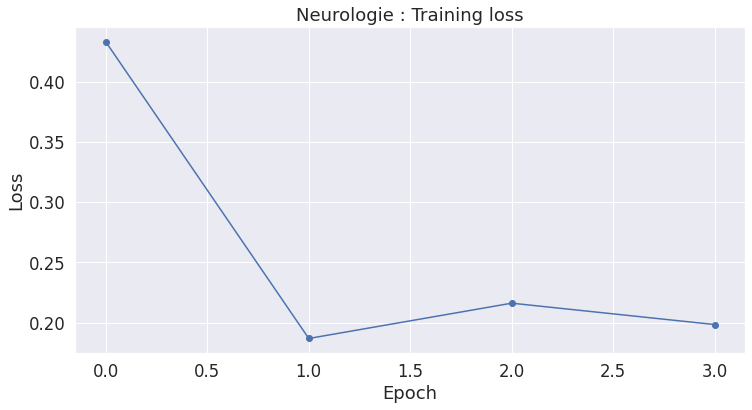

Nombre de sequence test: 300

   PREDICTION terminée.

Proportion des fausses prédictions : 0.0
F1_score_micro : 100.0
F1_score_macro : 100.0
Neurologie IS DONE!



Token indices sequence length is longer than the specified maximum sequence length for this model (658 > 512). Running this sequence through the model will result in indexing errors
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mod


======== Epoch 1 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.58
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.93
  Validation a pris: 0:00:00

======== Epoch 2 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.23
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.93
  Validation a pris: 0:00:00

======== Epoch 3 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.23
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.93
  Validation a pris: 0:00:00

======== Epoch 4 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.22
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.93
  Validation a pris: 0:00:00

Entrainement terminé!


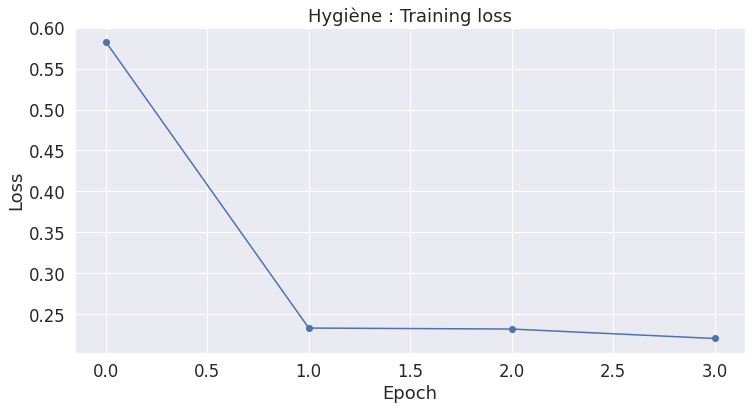

Nombre de sequence test: 300

   PREDICTION terminée.

Proportion des fausses prédictions : 1.2987012987012987
F1_score_micro : 98.7012987012987
F1_score_macro : 49.673202614379086
Hygiène IS DONE!



Token indices sequence length is longer than the specified maximum sequence length for this model (658 > 512). Running this sequence through the model will result in indexing errors
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mod


======== Epoch 1 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.57
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.93
  Validation a pris: 0:00:00

======== Epoch 2 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.11
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.93
  Validation a pris: 0:00:00

======== Epoch 3 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.09
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.93
  Validation a pris: 0:00:00

======== Epoch 4 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.08
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.93
  Validation a pris: 0:00:00

Entrainement terminé!


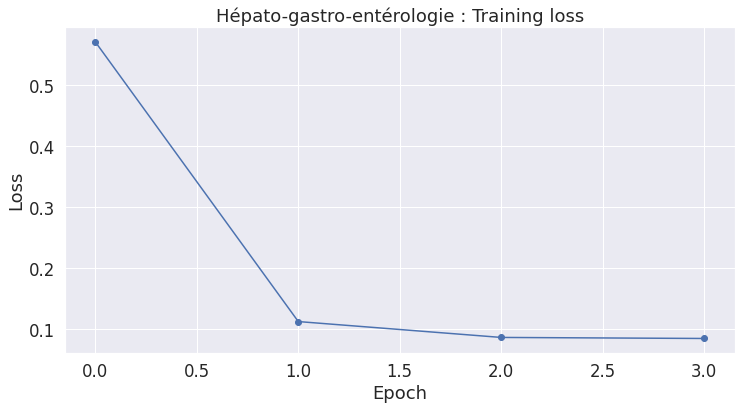

Nombre de sequence test: 300

   PREDICTION terminée.

Proportion des fausses prédictions : 0.0
F1_score_micro : 100.0
F1_score_macro : 100.0
Hépato-gastro-entérologie IS DONE!



Token indices sequence length is longer than the specified maximum sequence length for this model (658 > 512). Running this sequence through the model will result in indexing errors
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mod


======== Epoch 1 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.56
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.97
  Validation a pris: 0:00:00

======== Epoch 2 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.16
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.97
  Validation a pris: 0:00:00

======== Epoch 3 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.13
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.97
  Validation a pris: 0:00:00

======== Epoch 4 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.14
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.97
  Validation a pris: 0:00:00

Entrainement terminé!


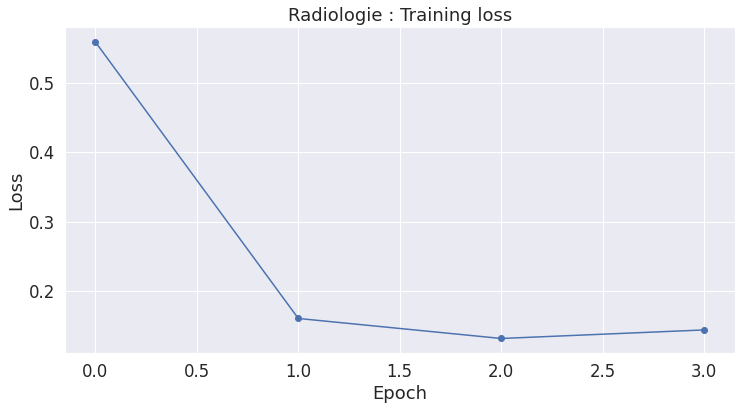

Nombre de sequence test: 300

   PREDICTION terminée.

Proportion des fausses prédictions : 12.987012987012985
F1_score_micro : 87.01298701298701
F1_score_macro : 46.52777777777778
Radiologie IS DONE!



Token indices sequence length is longer than the specified maximum sequence length for this model (658 > 512). Running this sequence through the model will result in indexing errors
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mod


======== Epoch 1 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.56
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.87
  Validation a pris: 0:00:00

======== Epoch 2 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.10
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.87
  Validation a pris: 0:00:00

======== Epoch 3 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.13
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.87
  Validation a pris: 0:00:00

======== Epoch 4 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.09
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.87
  Validation a pris: 0:00:00

Entrainement terminé!


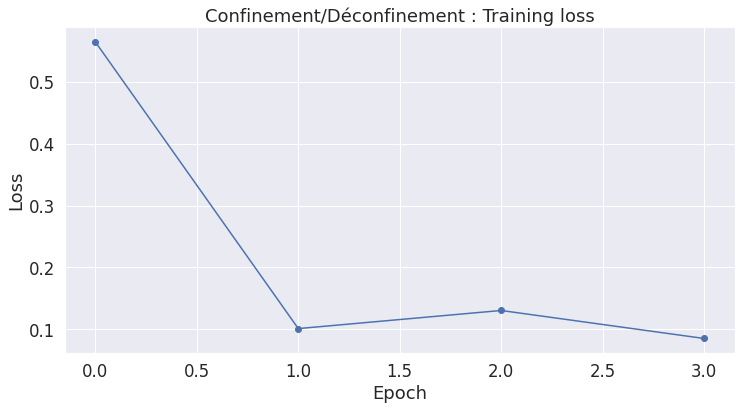

Nombre de sequence test: 300

   PREDICTION terminée.

Proportion des fausses prédictions : 0.0
F1_score_micro : 100.0
F1_score_macro : 100.0
Confinement/Déconfinement IS DONE!



Token indices sequence length is longer than the specified maximum sequence length for this model (658 > 512). Running this sequence through the model will result in indexing errors
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mod


======== Epoch 1 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.59
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.83
  Validation a pris: 0:00:00

======== Epoch 2 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.39
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.83
  Validation a pris: 0:00:00

======== Epoch 3 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.36
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.83
  Validation a pris: 0:00:00

======== Epoch 4 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.34
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.83
  Validation a pris: 0:00:00

Entrainement terminé!


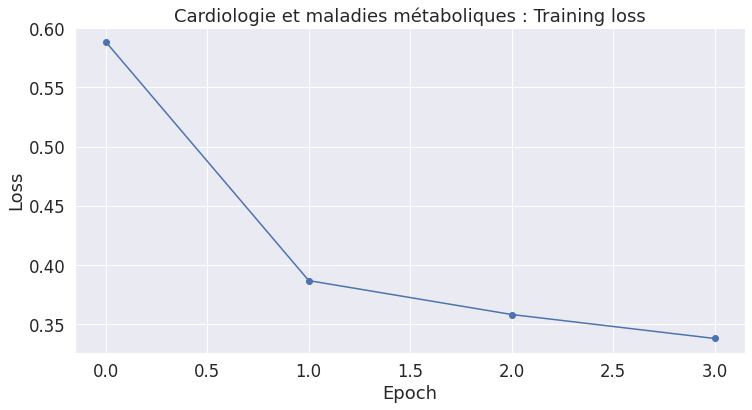

Nombre de sequence test: 300

   PREDICTION terminée.

Proportion des fausses prédictions : 2.5974025974025974
F1_score_micro : 97.40259740259741
F1_score_macro : 49.34210526315789
Cardiologie et maladies métaboliques IS DONE!



Token indices sequence length is longer than the specified maximum sequence length for this model (658 > 512). Running this sequence through the model will result in indexing errors
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mod


======== Epoch 1 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.60
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.97
  Validation a pris: 0:00:00

======== Epoch 2 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.18
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.97
  Validation a pris: 0:00:00

======== Epoch 3 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.20
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.97
  Validation a pris: 0:00:00

======== Epoch 4 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.18
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.97
  Validation a pris: 0:00:00

Entrainement terminé!


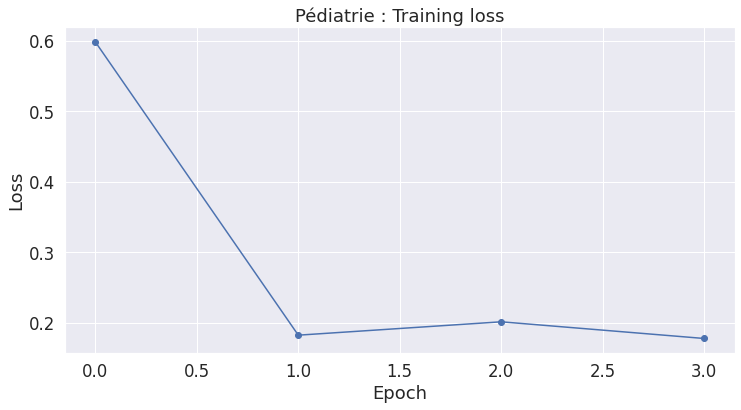

Nombre de sequence test: 300

   PREDICTION terminée.

Proportion des fausses prédictions : 11.688311688311687
F1_score_micro : 88.31168831168831
F1_score_macro : 46.89655172413793
Pédiatrie IS DONE!



Token indices sequence length is longer than the specified maximum sequence length for this model (658 > 512). Running this sequence through the model will result in indexing errors
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mod


======== Epoch 1 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.56
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.97
  Validation a pris: 0:00:00

======== Epoch 2 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.12
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.97
  Validation a pris: 0:00:00

======== Epoch 3 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.07
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.97
  Validation a pris: 0:00:00

======== Epoch 4 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.07
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.97
  Validation a pris: 0:00:00

Entrainement terminé!


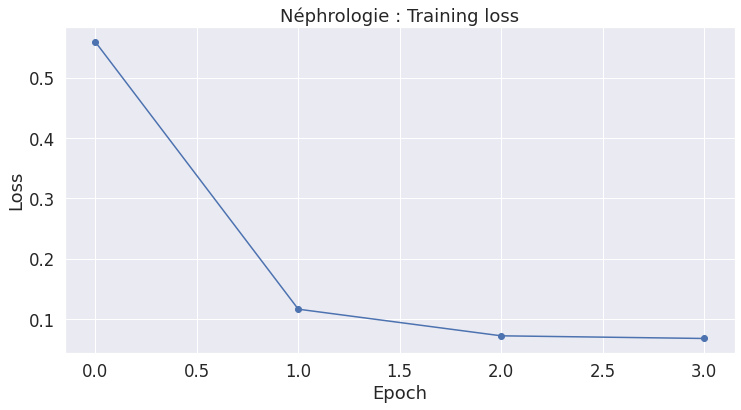

Nombre de sequence test: 300

   PREDICTION terminée.

Proportion des fausses prédictions : 0.0
F1_score_micro : 100.0
F1_score_macro : 100.0
Néphrologie IS DONE!



Token indices sequence length is longer than the specified maximum sequence length for this model (658 > 512). Running this sequence through the model will result in indexing errors
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mod


======== Epoch 1 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.55
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 1.00
  Validation a pris: 0:00:00

======== Epoch 2 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.04
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 1.00
  Validation a pris: 0:00:00

======== Epoch 3 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.01
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 1.00
  Validation a pris: 0:00:00

======== Epoch 4 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.00
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 1.00
  Validation a pris: 0:00:00

Entrainement terminé!


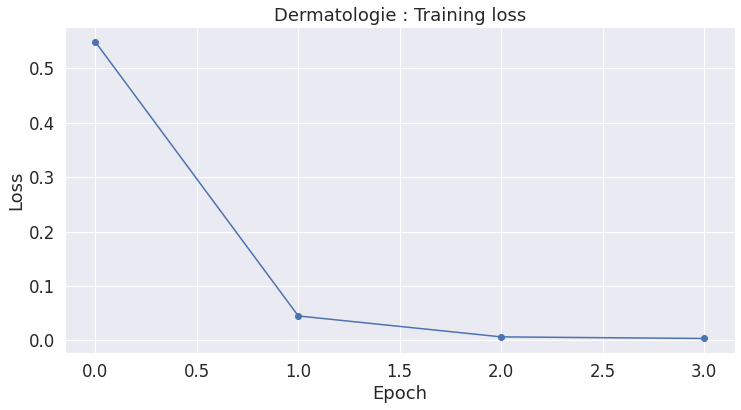

Nombre de sequence test: 300

   PREDICTION terminée.

Proportion des fausses prédictions : 0.0
F1_score_micro : 100.0
F1_score_macro : 100.0
Dermatologie IS DONE!



Token indices sequence length is longer than the specified maximum sequence length for this model (658 > 512). Running this sequence through the model will result in indexing errors
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mod


======== Epoch 1 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.60
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.97
  Validation a pris: 0:00:00

======== Epoch 2 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.39
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.97
  Validation a pris: 0:00:00

======== Epoch 3 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.36
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.97
  Validation a pris: 0:00:00

======== Epoch 4 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.39
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.97
  Validation a pris: 0:00:00

Entrainement terminé!


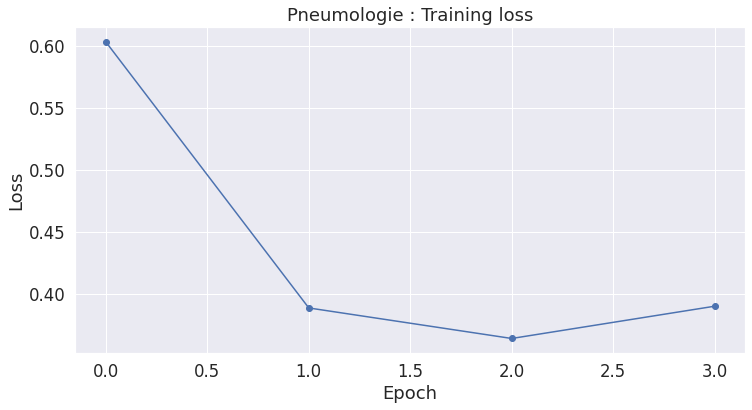

Nombre de sequence test: 300

   PREDICTION terminée.

Proportion des fausses prédictions : 0.0
F1_score_micro : 100.0
F1_score_macro : 100.0
Pneumologie IS DONE!



Token indices sequence length is longer than the specified maximum sequence length for this model (658 > 512). Running this sequence through the model will result in indexing errors
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mod


======== Epoch 1 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.61
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.77
  Validation a pris: 0:00:00

======== Epoch 2 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.47
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.77
  Validation a pris: 0:00:00

======== Epoch 3 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.42
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.77
  Validation a pris: 0:00:00

======== Epoch 4 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.43
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.77
  Validation a pris: 0:00:00

Entrainement terminé!


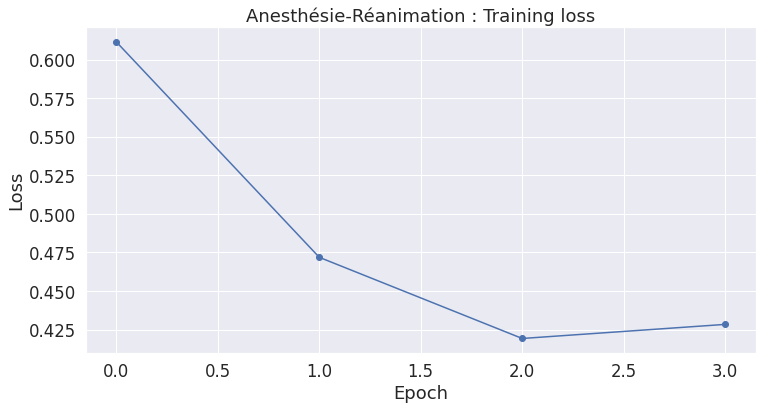

Nombre de sequence test: 300

   PREDICTION terminée.

Proportion des fausses prédictions : 7.792207792207792
F1_score_micro : 92.20779220779221
F1_score_macro : 47.97297297297297
Anesthésie-Réanimation IS DONE!



Token indices sequence length is longer than the specified maximum sequence length for this model (658 > 512). Running this sequence through the model will result in indexing errors
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mod


======== Epoch 1 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.57
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.97
  Validation a pris: 0:00:00

======== Epoch 2 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.22
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.97
  Validation a pris: 0:00:00

======== Epoch 3 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.19
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.97
  Validation a pris: 0:00:00

======== Epoch 4 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.17
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.97
  Validation a pris: 0:00:00

Entrainement terminé!


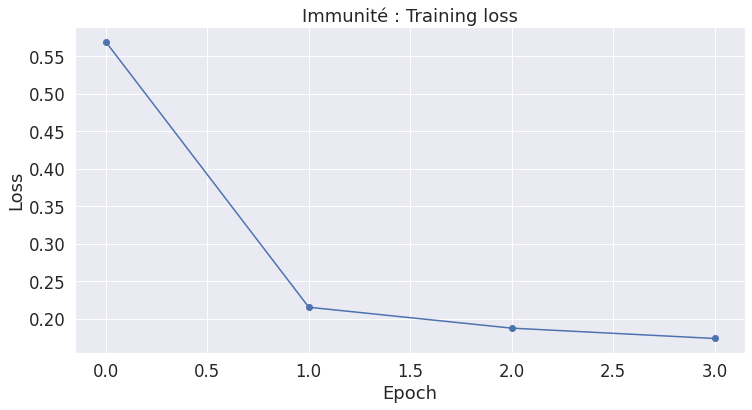

Nombre de sequence test: 300

   PREDICTION terminée.

Proportion des fausses prédictions : 2.5974025974025974
F1_score_micro : 97.40259740259741
F1_score_macro : 49.34210526315789
Immunité IS DONE!



Token indices sequence length is longer than the specified maximum sequence length for this model (658 > 512). Running this sequence through the model will result in indexing errors
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mod


======== Epoch 1 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.54
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 1.00
  Validation a pris: 0:00:00

======== Epoch 2 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.07
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 1.00
  Validation a pris: 0:00:00

======== Epoch 3 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.04
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 1.00
  Validation a pris: 0:00:00

======== Epoch 4 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.04
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 1.00
  Validation a pris: 0:00:00

Entrainement terminé!


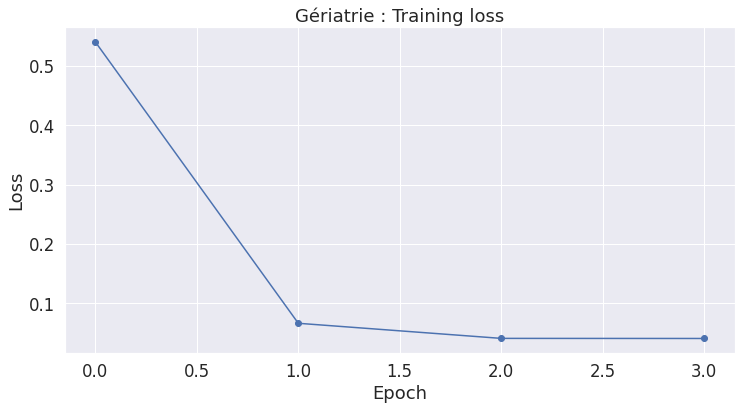

Nombre de sequence test: 300

   PREDICTION terminée.

Proportion des fausses prédictions : 1.2987012987012987
F1_score_micro : 98.7012987012987
F1_score_macro : 49.673202614379086
Gériatrie IS DONE!



Token indices sequence length is longer than the specified maximum sequence length for this model (658 > 512). Running this sequence through the model will result in indexing errors
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mod


======== Epoch 1 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.69
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.67
  Validation a pris: 0:00:00

======== Epoch 2 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.68
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.67
  Validation a pris: 0:00:00

======== Epoch 3 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.68
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.67
  Validation a pris: 0:00:00

======== Epoch 4 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.67
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.67
  Validation a pris: 0:00:00

Entrainement terminé!


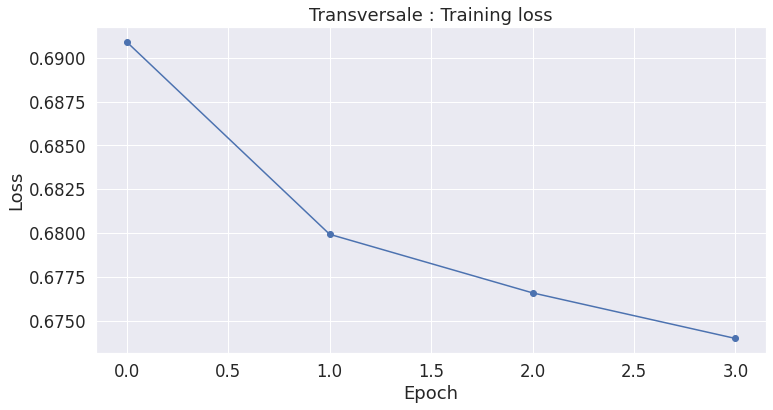

Nombre de sequence test: 300

   PREDICTION terminée.

Proportion des fausses prédictions : 42.857142857142854
F1_score_micro : 57.14285714285714
F1_score_macro : 36.36363636363637
Transversale IS DONE!



Token indices sequence length is longer than the specified maximum sequence length for this model (658 > 512). Running this sequence through the model will result in indexing errors
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mod


======== Epoch 1 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.56
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.90
  Validation a pris: 0:00:00

======== Epoch 2 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.14
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.90
  Validation a pris: 0:00:00

======== Epoch 3 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.14
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.90
  Validation a pris: 0:00:00

======== Epoch 4 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.13
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.90
  Validation a pris: 0:00:00

Entrainement terminé!


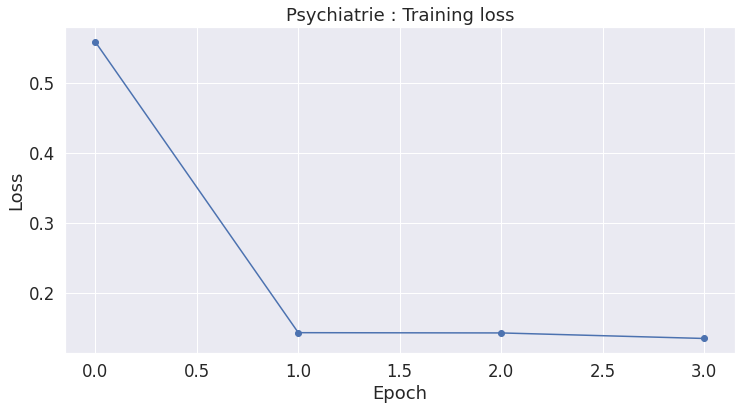

Nombre de sequence test: 300

   PREDICTION terminée.

Proportion des fausses prédictions : 5.194805194805195
F1_score_micro : 94.8051948051948
F1_score_macro : 48.666666666666664
Psychiatrie IS DONE!



Token indices sequence length is longer than the specified maximum sequence length for this model (658 > 512). Running this sequence through the model will result in indexing errors
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mod


======== Epoch 1 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.69
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.57
  Validation a pris: 0:00:00

======== Epoch 2 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.70
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.57
  Validation a pris: 0:00:00

======== Epoch 3 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.68
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.57
  Validation a pris: 0:00:00

======== Epoch 4 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.68
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.57
  Validation a pris: 0:00:00

Entrainement terminé!


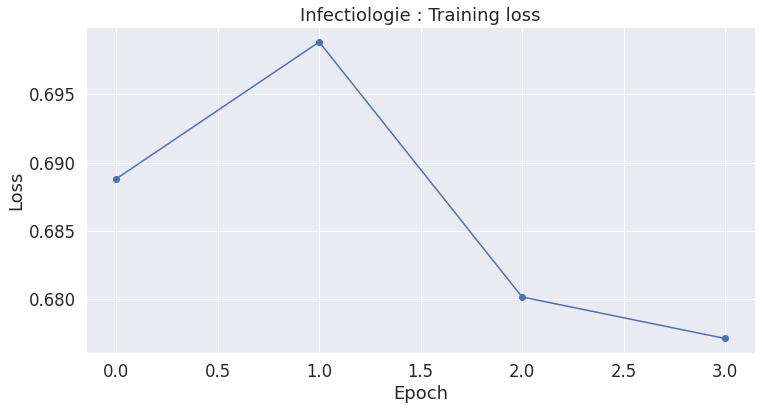

Nombre de sequence test: 300

   PREDICTION terminée.

Proportion des fausses prédictions : 9.090909090909092
F1_score_micro : 90.9090909090909
F1_score_macro : 47.61904761904761
Infectiologie IS DONE!



Token indices sequence length is longer than the specified maximum sequence length for this model (658 > 512). Running this sequence through the model will result in indexing errors
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mod


======== Epoch 1 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.52
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 1.00
  Validation a pris: 0:00:00

======== Epoch 2 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.10
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 1.00
  Validation a pris: 0:00:00

======== Epoch 3 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.06
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 1.00
  Validation a pris: 0:00:00

======== Epoch 4 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.06
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 1.00
  Validation a pris: 0:00:00

Entrainement terminé!


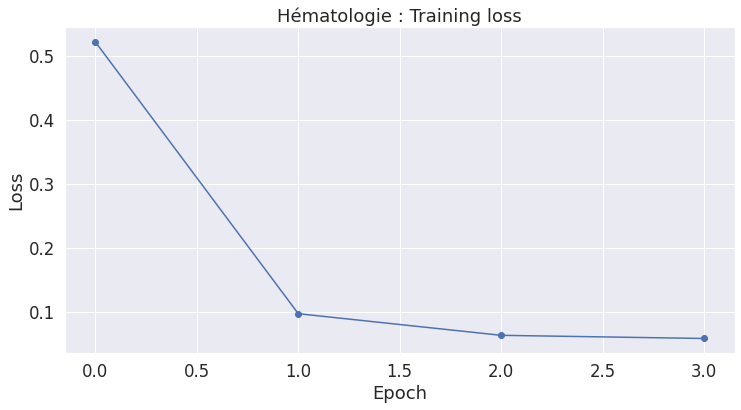

Nombre de sequence test: 300

   PREDICTION terminée.

Proportion des fausses prédictions : 0.0
F1_score_micro : 100.0
F1_score_macro : 100.0
Hématologie IS DONE!



Token indices sequence length is longer than the specified maximum sequence length for this model (658 > 512). Running this sequence through the model will result in indexing errors
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mod


======== Epoch 1 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.55
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 1.00
  Validation a pris: 0:00:00

======== Epoch 2 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.12
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 1.00
  Validation a pris: 0:00:00

======== Epoch 3 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.11
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 1.00
  Validation a pris: 0:00:00

======== Epoch 4 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.11
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 1.00
  Validation a pris: 0:00:00

Entrainement terminé!


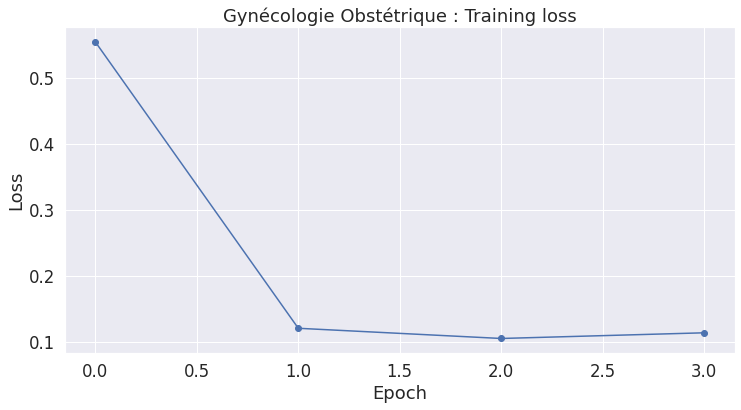

Nombre de sequence test: 300

   PREDICTION terminée.

Proportion des fausses prédictions : 2.5974025974025974
F1_score_micro : 97.40259740259741
F1_score_macro : 49.34210526315789
Gynécologie Obstétrique IS DONE!



Token indices sequence length is longer than the specified maximum sequence length for this model (658 > 512). Running this sequence through the model will result in indexing errors
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mod


======== Epoch 1 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.61
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.97
  Validation a pris: 0:00:00

======== Epoch 2 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.39
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.97
  Validation a pris: 0:00:00

======== Epoch 3 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.39
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.97
  Validation a pris: 0:00:00

======== Epoch 4 / 4 ========
Entrainement...

 loss Moyen de l'entrainement: 0.36
  Training epcoh a pris: 0:00:05

Lancement de Validation...
  Accuracy: 0.97
  Validation a pris: 0:00:00

Entrainement terminé!


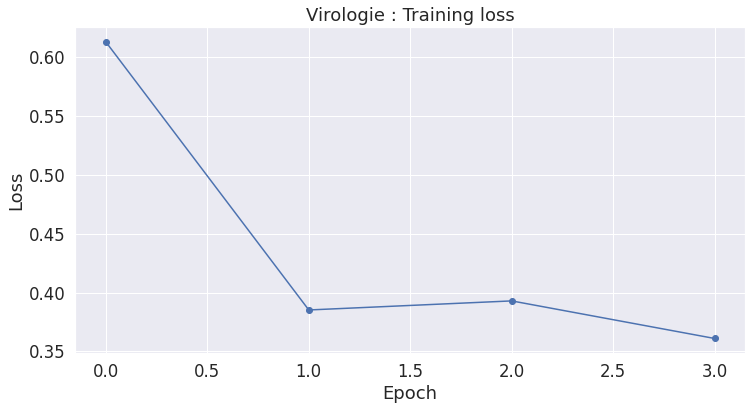

Nombre de sequence test: 300

   PREDICTION terminée.

Proportion des fausses prédictions : 14.285714285714285
F1_score_micro : 85.71428571428571
F1_score_macro : 46.15384615384615
Virologie IS DONE!

Accuracy Score = 0.9398496240601504

F1 Score (Micro) = 0.9398496240601504

F1 Score (Macro) = 0.4844961240310078

Les résultats des classifieurs binaires:


,Neurologie,Hygiène,Hépato-gastro-entérologie,Radiologie,Confinement/Déconfinement,Cardiologie et maladies métaboliques,Pédiatrie,Néphrologie,Dermatologie,Pneumologie,Anesthésie-Réanimation,Immunité,Gériatrie,Transversale,Psychiatrie,Infectiologie,Hématologie,Gynécologie Obstétrique,Virologie
f1_score_micro,100.0,98.701299,100.0,87.012987,100.0,97.402597,88.311688,100.0,100.0,100.0,92.207792,97.402597,98.701299,57.142857,94.805195,90.909091,100.0,97.402597,85.714286
proportion_des_prédictions_fausses,0.0,1.298701,0.0,12.987013,0.0,2.597403,11.688312,0.0,0.0,0.0,7.792208,2.597403,1.298701,42.857143,5.194805,9.090909,0.0,2.597403,14.285714
f1_score_macro,100.0,49.673203,100.0,46.527778,100.0,49.342105,46.896552,100.0,100.0,100.0,47.972973,49.342105,49.673203,36.363636,48.666667,47.619048,100.0,49.342105,46.153846


In [29]:
all_specs_model()